In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

В данном файле содержатся выкладки по всем графикам в презентации.

Для удобства запуска они устроены так:

1. Импортирование файла 'purchases_processed.csv', созданного в предыдущем файле.
2. Преобразования над датафреймом
3. Создание изображения

In [7]:
prp = pd.read_csv('purchases_processed.csv', usecols=['purchase_sum', 'transaction_datetime', 'age', 'gender'])

# Так как у некоторых установлен возраст как значения больше 100 или отрицательные значения
stats = prp[(prp.age > 0) & (prp.age < 100)].groupby(['transaction_datetime', 'age']).purchase_sum.sum().reset_index()
# Рассчитываем сумму, принесенную определенной возрастной группой

# Распределение для 30 декабря 2018
t1 = stats[stats.transaction_datetime == '2018-12-30'][['age', 'purchase_sum']]
# Среднее значение в каждой возрастной группе по всем дням
t2 = stats.groupby(['age']).purchase_sum.mean().astype(int).reset_index()

In [8]:
# Объединяем результаты для сравнения и присваиваем им названия колонок
t1 = pd.merge(t1, t2, on='age', how='outer')
t1.columns = ['age', 'sum_new_year', 'sum_usual']

# Получаем сравнительные статистики: отличие от среднего, прирост по сравнению со средним значением
t1['diff'] = t1.sum_new_year - t1.sum_usual
t1['ratio'] = t1.sum_new_year / t1.sum_usual

# Так как для некоторых возрастов значения равны отсутствуют, и, сответственно, есть пропущенные строки (их не будет дополнять seaborn)
t1 = t1[['age', 'diff', 'ratio']].set_index('age').reindex(range(101))

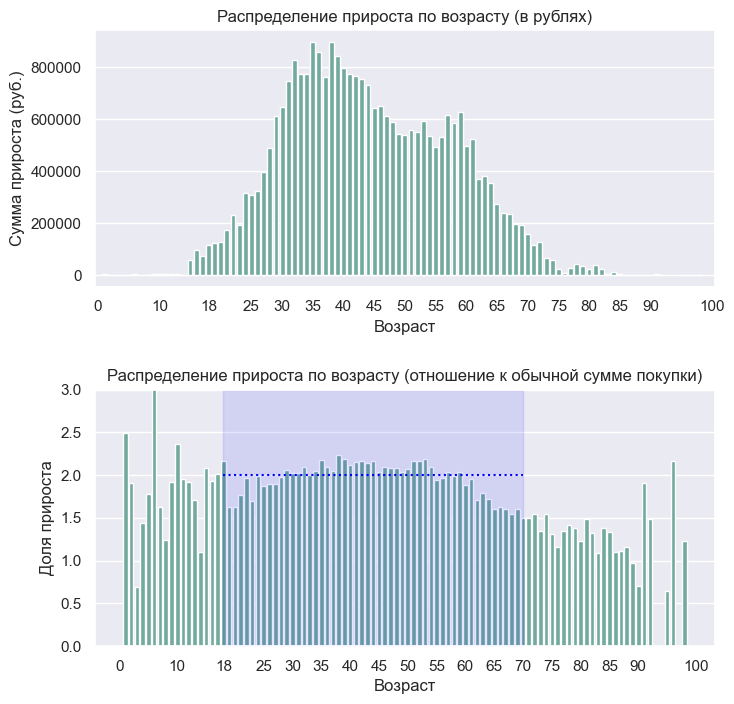

In [11]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(8, 8))

plt.subplot(211)
plt.title("Распределение прироста по возрасту (в рублях)")
sns.barplot(data=t1, x='age', y='diff', color='#69b3a2')
plt.xticks(ticks=[0, 10, 18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 100])
plt.xlabel("Возраст")
plt.ylabel("Сумма прироста (руб.)")

plt.subplots_adjust(hspace=0.4)

plt.subplot(212)
plt.title("Распределение прироста по возрасту (отношение к обычной сумме покупки)")
sns.barplot(data=t1, x='age', y='ratio', color='#69b3a2')
plt.hlines(y=2, xmin=18, xmax=70, color='blue', linestyles='dotted')
plt.fill_between(x=[18, 70], y1=[3, 3], color='blue', alpha=0.1)
plt.xticks(ticks=[0, 10, 18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 100])
plt.xlabel("Возраст")
plt.ylabel("Доля прироста")
plt.ylim(0, 3)

#plt.savefig("output.jpg", dpi=500)
plt.show()

In [13]:
table = pd.read_csv('purchases_processed.csv', usecols=['purchase_sum', 'transaction_datetime'])
table = table.groupby('transaction_datetime').agg({'purchase_sum': 'sum'}).reset_index()
table.purchase_sum = np.round(table.purchase_sum / 1000000, 1)

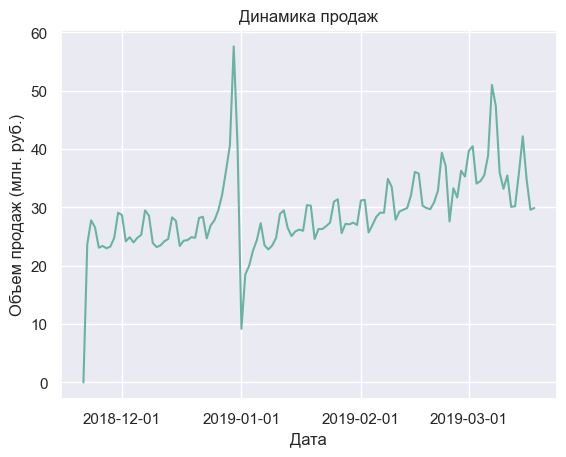

In [15]:
plt.title('Динамика продаж')
sns.lineplot(table, x='transaction_datetime', y='purchase_sum', color='#69b3a2')
plt.xticks(['2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01'])
plt.xlabel('Дата')
plt.ylabel('Объем продаж (млн. руб.)')
#plt.savefig("output.jpg", dpi=500)
plt.show()

In [16]:
clients = pd.read_csv('clients.csv', usecols=['client_id', 'first_issue_date', 'gender'])
clients.first_issue_date = pd.to_datetime(clients.first_issue_date).dt.date

clients['month'] = pd.to_datetime(clients.first_issue_date).dt.month
clients['year'] =pd.to_datetime(clients.first_issue_date).dt.year

t1 = clients.groupby(['year', 'month', 'gender']).client_id.count().reset_index()
t1 = pd.merge(t1, clients.groupby(['year', 'month']).client_id.count().reset_index(), on=['year', 'month',])
t1.columns = ['year', 'month', 'gender', 'client_id', 'client_id_total']
t1['ratio'] = (t1.client_id / t1.client_id_total) * 100
t1 = t1.sort_values(by=['year', 'month'])
t1['time'] = t1['year'].astype(str) + '/' + t1['month'].astype(str)

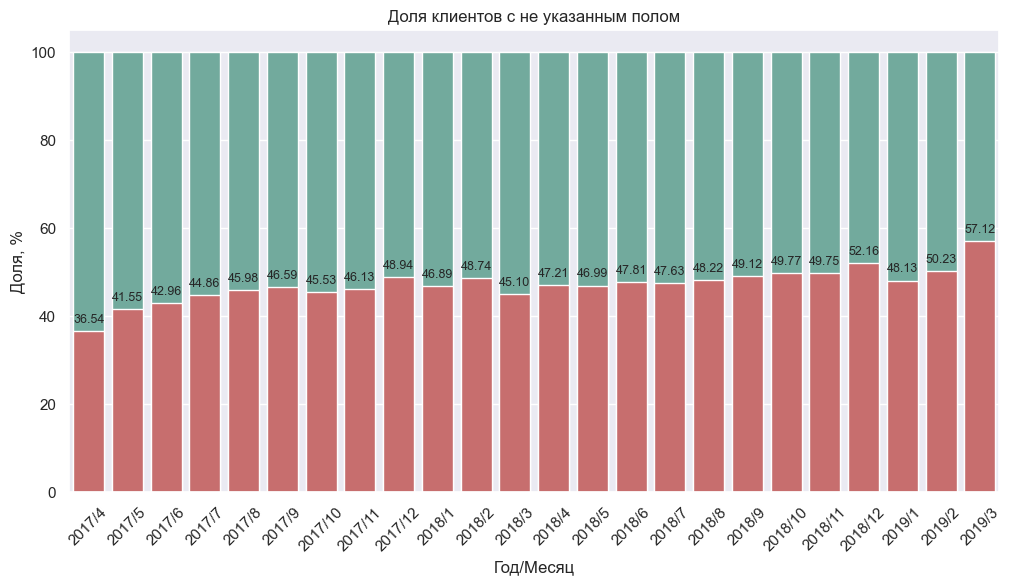

In [20]:
plt.figure(figsize=(12, 6))
plt.title('Доля клиентов с не указанным полом')
sns.barplot(x=t1[t1.gender == 'U'].time, y=np.ones(t1[t1.gender == 'U'].shape[0])* 100, color='#69b3a2')
plots = sns.barplot(t1[t1.gender == 'U'], x='time', y='ratio', color='#D65F5F')


for bar in plots.patches:
    if bar.get_height() != 100:
        plots.annotate(format(bar.get_height(), '.2f'), 
                    (bar.get_x() + bar.get_width() / 2, 
                        bar.get_height()), ha='center', va='center',
                    size=9, xytext=(0, 8),
                    textcoords='offset points')



plt.xlabel('Год/Месяц')
plt.ylabel('Доля, %')
plt.xticks(rotation=45)
#plt.savefig("output.jpg", dpi=500)
plt.show()

In [22]:
for_piechart = clients.gender.value_counts().reset_index()
for_piechart.gender = ['Неизвестно', "Женщины", "Мужчины"]

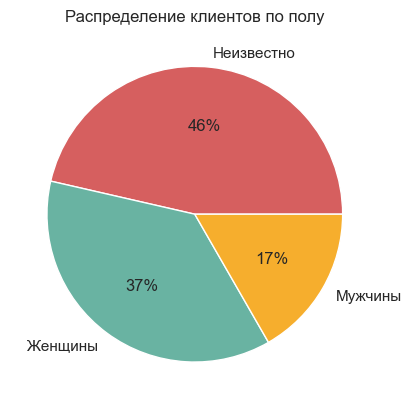

In [23]:
plt.title('Распределение клиентов по полу')
plt.pie(for_piechart['count'], labels =for_piechart.gender, colors =['#D65F5F', '#69b3a2', '#F6AE2D'], autopct='%.0f%%')
#plt.savefig("output.jpg", dpi=500)
plt.show()

In [25]:
purchases = pd.read_csv('purchases_processed.csv', usecols=['client_id', 'purchase_sum', 'first_issue_date', 'transaction_datetime', 'weeks_since_card'])

In [26]:
purchases_new_clients = purchases[(purchases.first_issue_date > '2018-11-11') 
                                  & (purchases.weeks_since_card <= 3)
                                 & (purchases.weeks_since_card >= 0)].reset_index(drop=True)

purchases_new_clients.first_issue_date = pd.to_datetime(purchases_new_clients.first_issue_date).dt.to_period('M')

In [27]:
ppr = purchases_new_clients.groupby(['client_id', 'first_issue_date', 'weeks_since_card']).purchase_sum.sum().reset_index()
ppr = ppr.groupby(['first_issue_date', 'weeks_since_card']).purchase_sum.mean().reset_index()
ppr.weeks_since_card = ppr.weeks_since_card + 1
ppr.purchase_sum = ppr.purchase_sum.astype(int)

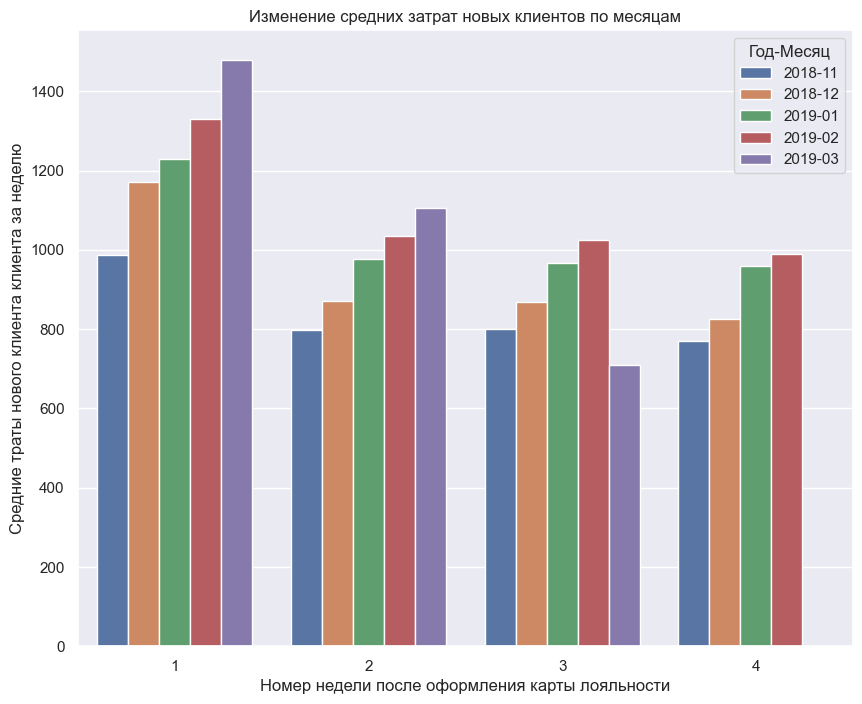

In [28]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 8))
sns.barplot(ppr, x='weeks_since_card', y='purchase_sum', hue='first_issue_date')
plt.title('Изменение средних затрат новых клиентов по месяцам')
plt.legend(['Ноябрь 2018', 'Декабрь 2018', 'Январь 2019', 'Февраль 2019', 'Март 2019'])
plt.ylabel('Средние траты нового клиента клиента за неделю')
plt.xlabel('Номер недели после оформления карты лояльности')
plt.legend(title='Год-Месяц')
#plt.savefig("output.jpg", dpi=500)
plt.show()

In [31]:
ppr = purchases_new_clients.groupby(['client_id', 'first_issue_date', 'weeks_since_card']).purchase_sum.sum().reset_index()
ppr = ppr.groupby(['first_issue_date', 'weeks_since_card']).purchase_sum.mean().reset_index()
ppr.weeks_since_card = ppr.weeks_since_card + 1
ppr.purchase_sum = ppr.purchase_sum.astype(int)

In [32]:
ppr_ = ppr.pivot_table(index='first_issue_date', values='purchase_sum', columns='weeks_since_card').fillna(0).astype(int).reset_index()
ppr_.columns = ['first_issue_date', '1', '2', '3', '4']
ppr_['От 1 недели ко 2'] = (1 - ppr_['2'] / ppr_['1']) * 100
ppr_['От 2 недели к 3'] = (1 - ppr_['3'] / ppr_['2']) * 100
ppr_['От 3 недели к 4'] = (1 - ppr_['4'] / ppr_['3']) * 100
ppr_ = ppr_.melt(id_vars='first_issue_date', value_vars=['От 1 недели ко 2', 'От 2 недели к 3', 'От 3 недели к 4'], var_name='Неделя', value_name='ratio')
ppr_ = ppr_.rename({'first_issue_date': 'Месяц'}, axis=1)

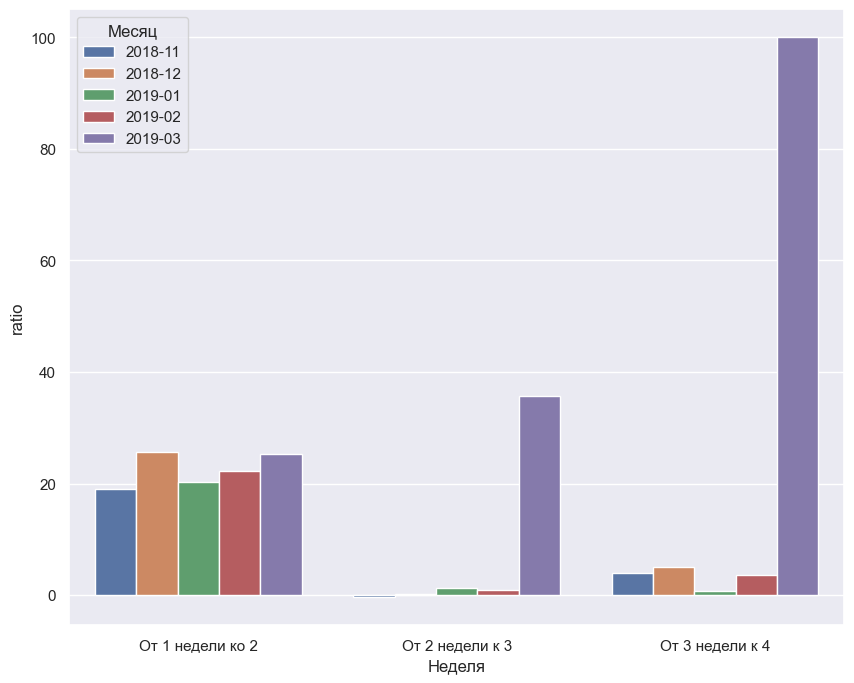

In [38]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 8))
sns.barplot(ppr_, x='Неделя', y='ratio', hue='Месяц')
plt.show()

In [41]:
purchases = pd.read_csv('purchases_processed.csv', usecols=['client_id', 'purchase_sum', 'first_issue_date', 'transaction_datetime', 'weeks_since_card'])

In [42]:
purchases_new_clients = purchases[(purchases.first_issue_date > '2018-11-11') 
                                  & (purchases.weeks_since_card <= 3)
                                 & (purchases.weeks_since_card >= 0)].reset_index(drop=True)
purchases_new_clients.weeks_since_card = purchases_new_clients.weeks_since_card + 1
purchases_new_clients.first_issue_date = pd.to_datetime(purchases_new_clients.first_issue_date).dt.to_period('M')
ppr = purchases_new_clients.groupby(['client_id', 'first_issue_date', 'weeks_since_card']).purchase_sum.sum().reset_index()

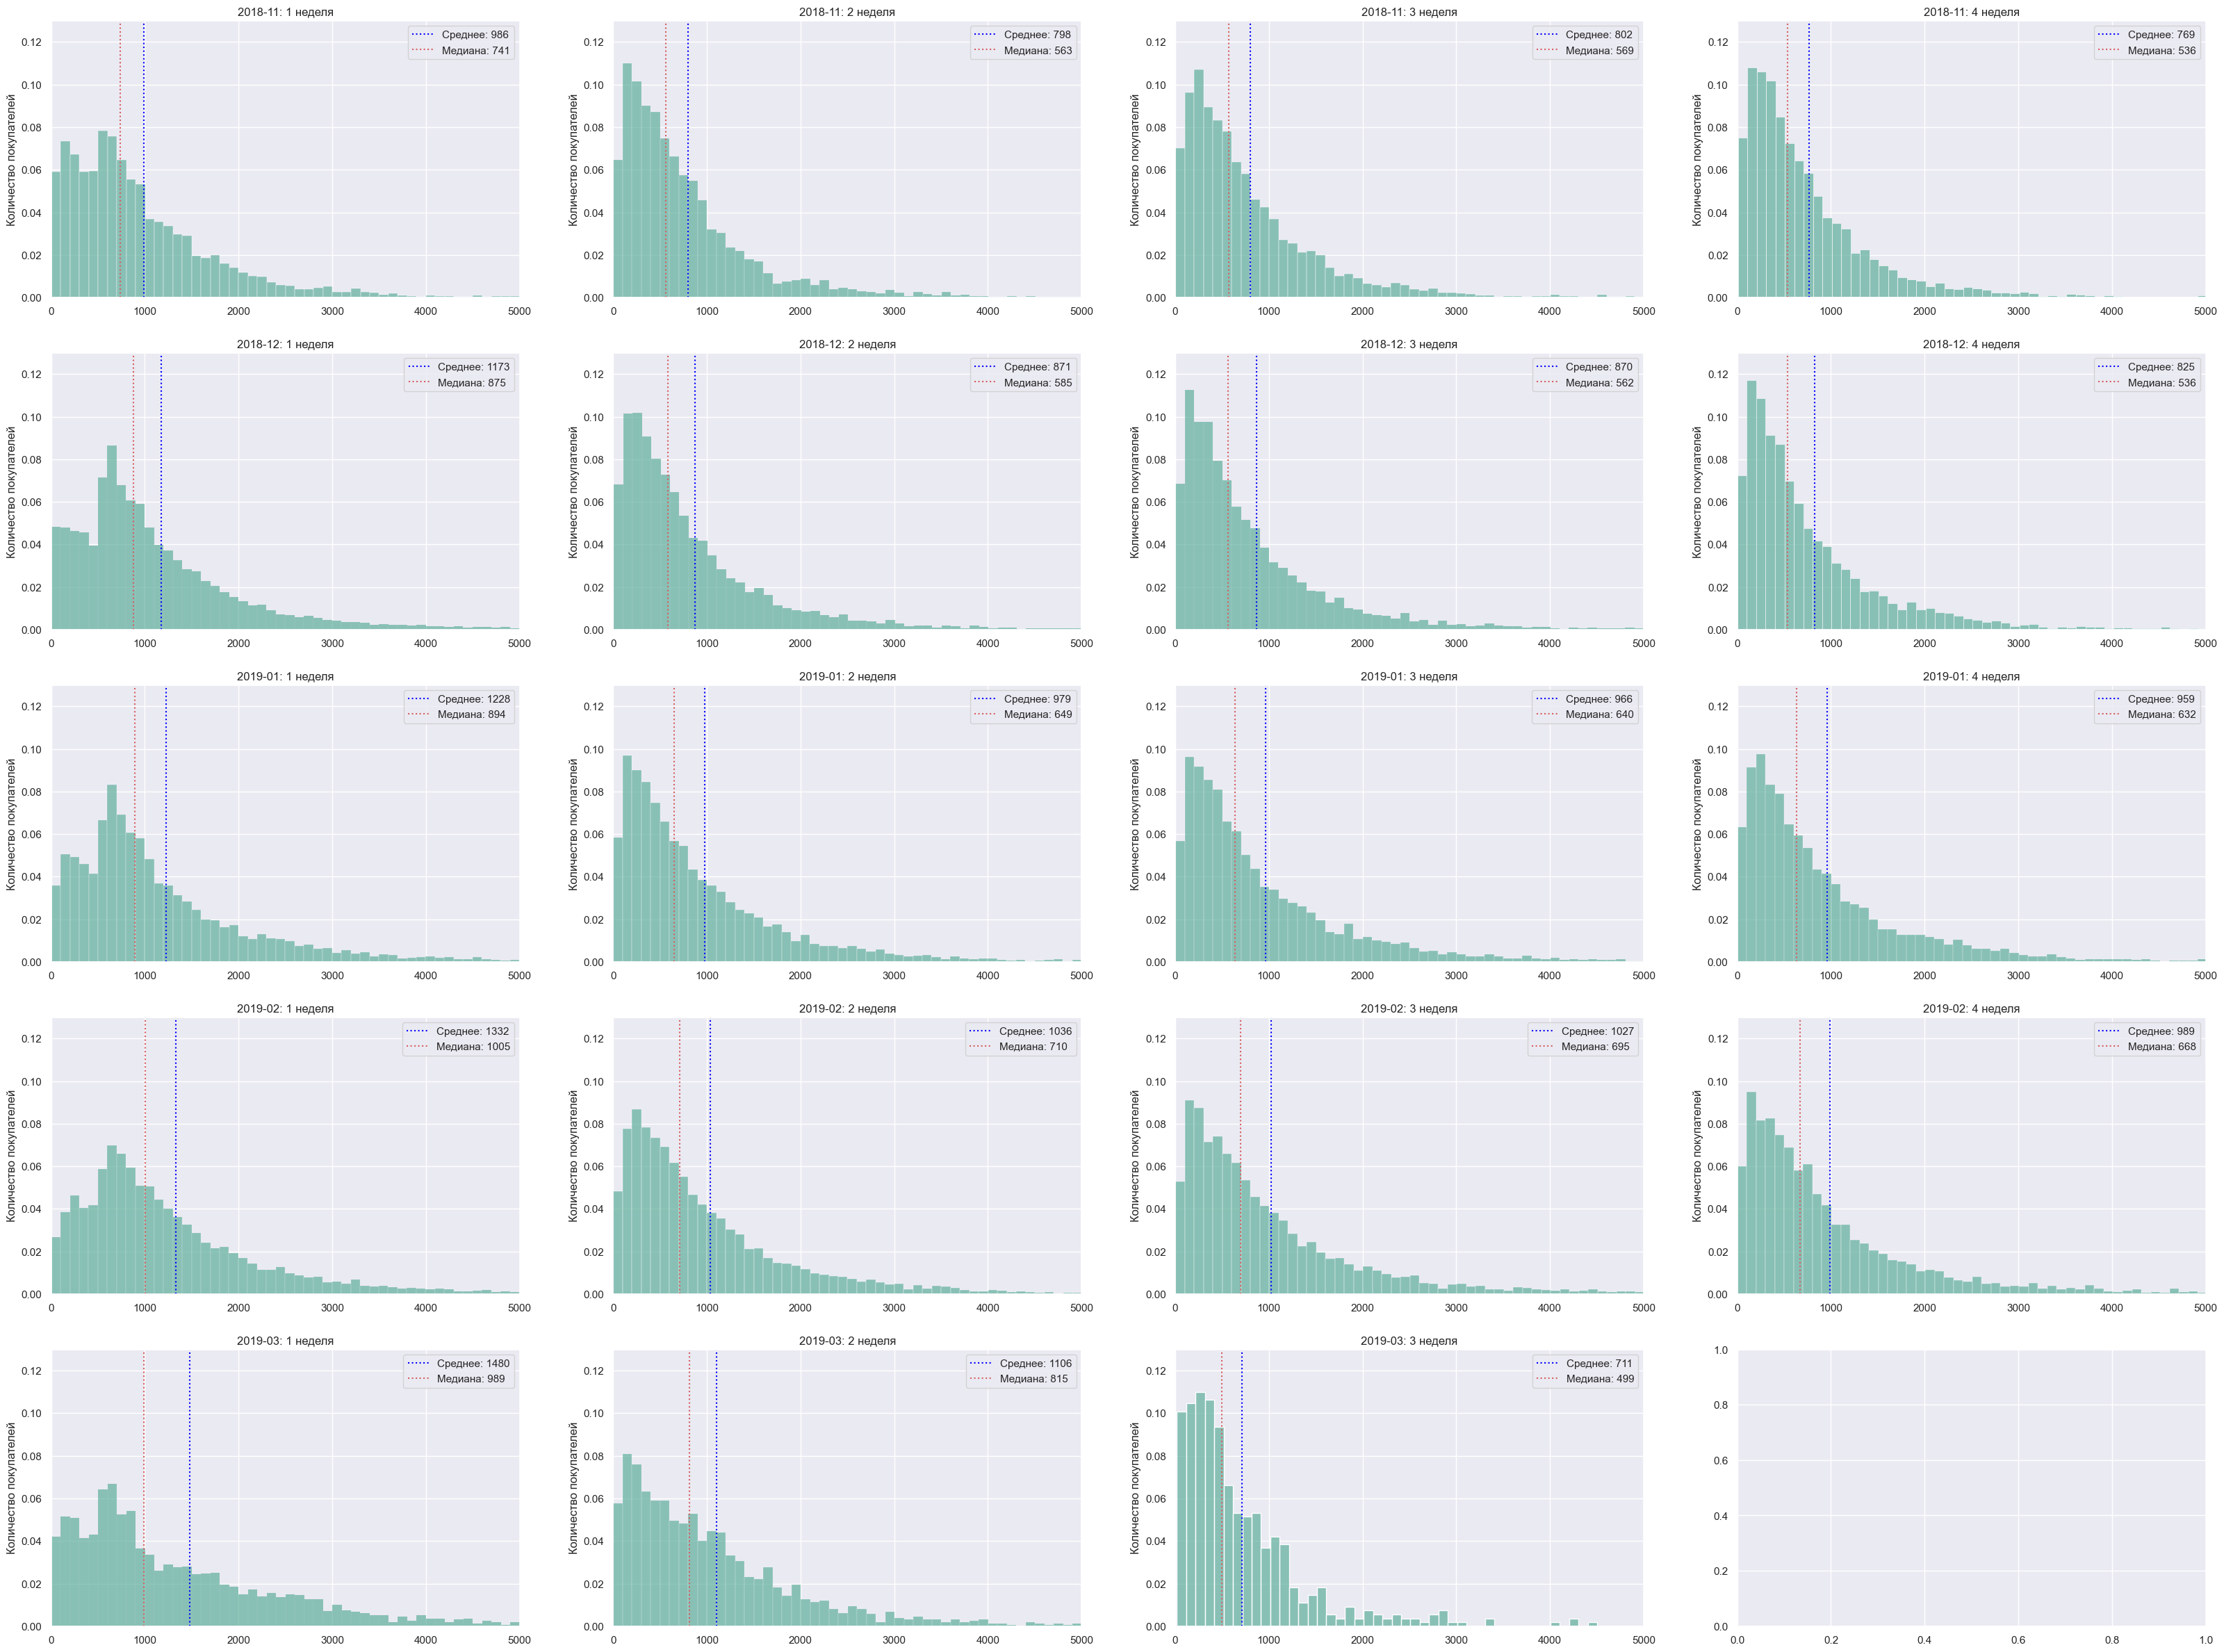

In [43]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(40, 30))

for i, el in enumerate(ppr.first_issue_date.sort_values().unique().tolist()):
    table = ppr[ppr.first_issue_date == el]
    for el2 in [1, 2, 3, 4]:
        plt.subplot(5, 4, 4*i+el2)
        sample = table[table.weeks_since_card == el2].purchase_sum
        if sample.shape[0] > 0:
            ax = sns.histplot(sample, binwidth=100, stat='probability', color='#69b3a2')
            sample_mean = sample.mean()
            sample_median = sample.median()
            legend = False
            if sample_mean != np.nan:
                legend = True
                plt.vlines(sample_mean, ymin=0, ymax=0.13, label=f'Среднее: {np.round(sample_mean).astype(int)}', color='blue', linestyles='dotted')
            if sample_median != np.nan:
                legend = True
                plt.vlines(sample_median, ymin=0, ymax=0.13, label=f'Медиана: {np.round(sample_median).astype(int)}', color='#D65F5F', linestyles='dotted')
            plt.title(f'{el}: {el2} неделя')
            plt.ylabel('Количество покупателей')
            plt.xlabel('')
            if legend:
                plt.legend()
            plt.xlim((0, 5000))
            plt.ylim((0, 0.13))
#plt.savefig("output.jpg", dpi=500)
plt.show()

In [44]:
purchases = pd.read_csv('purchases_processed.csv', usecols=['client_id', 'purchase_sum', 'first_issue_date', 'transaction_datetime', 'weeks_since_card'])
purchases_new_clients = purchases[(purchases.first_issue_date > '2018-11-11') 
                                  & (purchases.weeks_since_card <= 3)
                                 & (purchases.weeks_since_card >= 0)].reset_index(drop=True)
purchases_new_clients.weeks_since_card = purchases_new_clients.weeks_since_card + 1
purchases_new_clients.first_issue_date = pd.to_datetime(purchases_new_clients.first_issue_date).dt.to_period('M')
purchases_new_clients = purchases_new_clients.groupby(['client_id', 'first_issue_date', 'weeks_since_card']).purchase_sum.sum().reset_index()
purchases_new_clients = purchases_new_clients.pivot(index=['client_id', 'first_issue_date'], values='purchase_sum', columns='weeks_since_card').fillna(0).astype(int).reset_index()
purchases_new_clients.columns = ['client_id', 'first_issue_date', '1', '2', '3', '4']

In [45]:
p = purchases_new_clients[(purchases_new_clients['1'] != 0) & (purchases_new_clients['2'] != 0)]
purchases_new_clients['Между 1 и 2 неделями'] = p['2'] - p['1']
p = purchases_new_clients[(purchases_new_clients['2'] != 0) & (purchases_new_clients['3'] != 0)]
purchases_new_clients['Между 2 и 3 неделями'] = p['3'] - p['2']
p = purchases_new_clients[(purchases_new_clients['3'] != 0) & (purchases_new_clients['4'] != 0)]
purchases_new_clients['Между 3 и 4 неделями'] = p['4'] - p['3']

In [46]:
ppr = purchases_new_clients.melt(id_vars=['first_issue_date'], 
                                 value_vars=['Между 1 и 2 неделями', 'Между 2 и 3 неделями', 'Между 3 и 4 неделями'], var_name='weeks', value_name='difference')

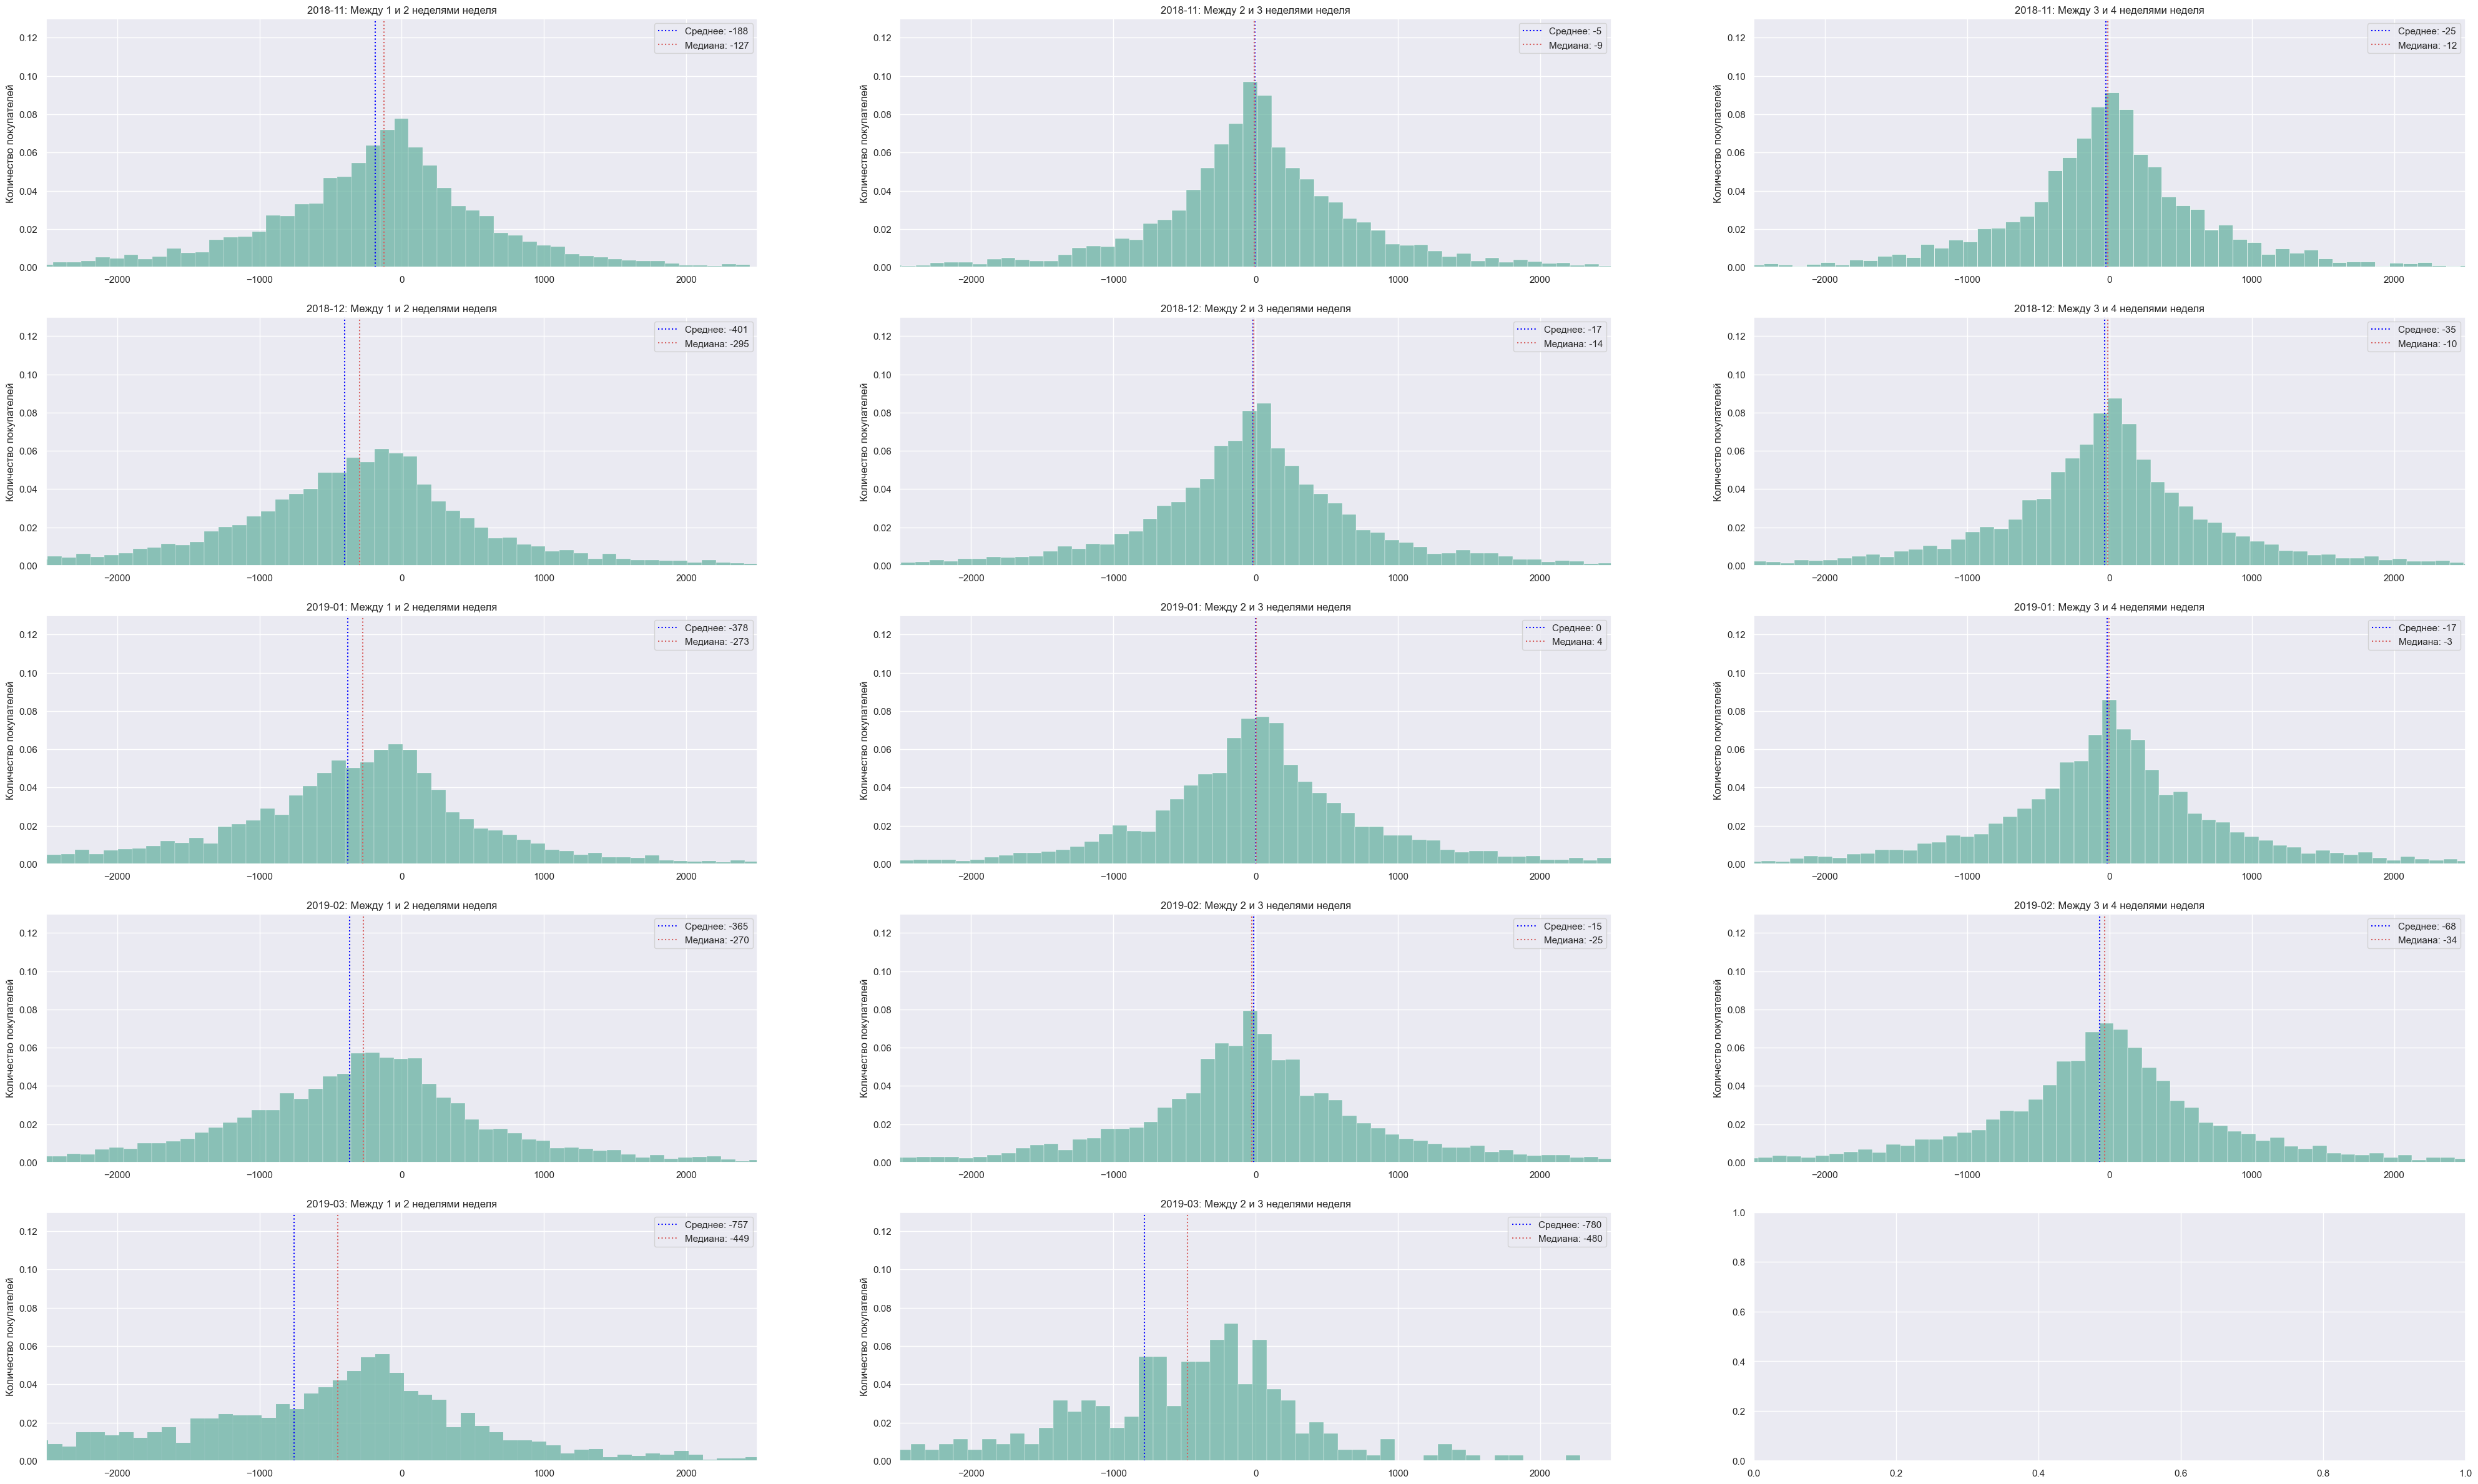

In [47]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(50, 30))

for i, el in enumerate(ppr.first_issue_date.sort_values().unique().tolist()):
    table = ppr[ppr.first_issue_date == el]
    for j, el2 in enumerate(['Между 1 и 2 неделями', 'Между 2 и 3 неделями', 'Между 3 и 4 неделями']):
        plt.subplot(5, 3, 3*i+(j+1))
        sample = table[table.weeks == el2].difference.dropna()
        if sample.shape[0] > 0:
            ax = sns.histplot(sample, binwidth=100, stat='probability', color='#69b3a2')
            sample_mean = sample.mean()
            sample_median = sample.median()
            legend = False

            if sample_mean != np.nan:
                legend = True
                plt.vlines(sample_mean, ymin=0, ymax=0.13, label=f'Среднее: {np.round(sample_mean).astype(int)}', color='blue', linestyles='dotted')
            if sample_median != np.nan:
                legend = True
                plt.vlines(sample_median, ymin=0, ymax=0.13, label=f'Медиана: {np.round(sample_median).astype(int)}', color='#D65F5F', linestyles='dotted')
            plt.title(f'{el}: {el2} неделя')
            plt.ylabel('Количество покупателей')
            plt.xlabel('')
            if legend:
                plt.legend()
            plt.xlim((-2500, 2500))
            plt.ylim((0, 0.13))
#plt.savefig("output.jpg", dpi=500)
plt.show()

In [49]:
from scipy.stats import ttest_ind, normaltest, ttest_1samp
import statsmodels.stats.api as sms

In [48]:
samples = []
for i, el in enumerate(ppr.first_issue_date.sort_values().unique().tolist()):
    table = ppr[ppr.first_issue_date == el]
    samples2 = []
    for j, el2 in enumerate(['Между 1 и 2 неделями', 'Между 2 и 3 неделями', 'Между 3 и 4 неделями']):
        samples2.append(table[table.weeks == el2].difference.dropna().to_numpy())
    samples.append(samples2)

Видим, что не только визуально, но и статистическим тестом подтверждается нормальность распределения

In [50]:
print(normaltest(samples[0][0]).pvalue, normaltest(samples[1][0]).pvalue)
print(normaltest(samples[0][1]).pvalue, normaltest(samples[1][1]).pvalue)
print(normaltest(samples[0][2]).pvalue, normaltest(samples[1][2]).pvalue)

0.0 0.0
0.0 0.0
1.1875591223511282e-157 0.0


Следовательно, можем применить тест о неравенстве средних

In [51]:
print(ttest_ind(samples[0][0], samples[1][0]))
print(ttest_ind(samples[0][1], samples[1][1]))
print(ttest_ind(samples[0][2], samples[1][2]))

TtestResult(statistic=8.21667202353553, pvalue=2.3116795887399744e-16, df=11719.0)
TtestResult(statistic=0.5319796096938543, pvalue=0.5947525304032157, df=9521.0)
TtestResult(statistic=0.4817849721446798, pvalue=0.6299695809053886, df=9695.0)


In [52]:
result = []
for i in range(3):
    lst = []
    for j in range(3):
        lst.append(ttest_ind(samples[i][j], samples[i+1][j], equal_var=False).pvalue)
    result.append(lst)

In [53]:
result

[[5.0768729146552265e-17, 0.5824766989279762, 0.6132173193574286],
 [0.2715427503389256, 0.41810945716067127, 0.37004824474342324],
 [0.5731732561631233, 0.48674646043599357, 0.024834264152688208]]

In [54]:
result = []
for i in range(3):
    lst = []
    for j in range(3):
        x1, x2 = sms.CompareMeans(sms.DescrStatsW(samples[i+1][j]), 
                                    sms.DescrStatsW(samples[i][j])).tconfint_diff(usevar='unequal')   
        lst.append([np.round(x1, 2), np.round(x2, 2)])
    result.append(lst)

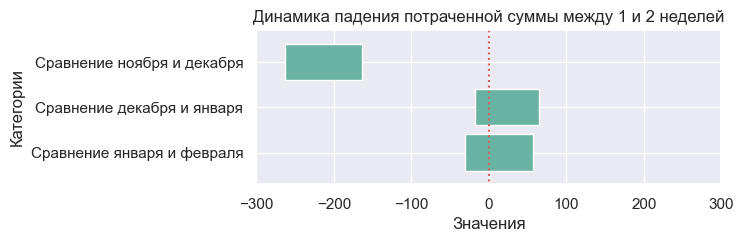

In [55]:
categories = ['Сравнение ноября и декабря', 'Сравнение декабря и января', 'Сравнение января и февраля'][::-1]
lefts = [result[0][0][0], result[1][0][0], result[2][0][0]][::-1]
values = [result[0][0][1], result[1][0][1], result[2][0][1]][::-1]

fig, ax = plt.subplots(figsize=(6, 2))

bars = ax.barh(categories, values, color='#69b3a2')

for bar, left in zip(bars, lefts):
    bar.set_x(left)
    bar.set_width(bar.get_width() - left)

ax.set_ylabel('Категории')
ax.set_xlabel('Значения')
ax.set_title('Динамика падения потраченной суммы между 1 и 2 неделей')
plt.xlim(-300, 300)
plt.ylim(-0.7, 2.7)
plt.vlines(0, ymin=-1, ymax=3, color='#D65F5F', linestyles='dotted')
plt.savefig("output.jpg", dpi=500)
plt.show()

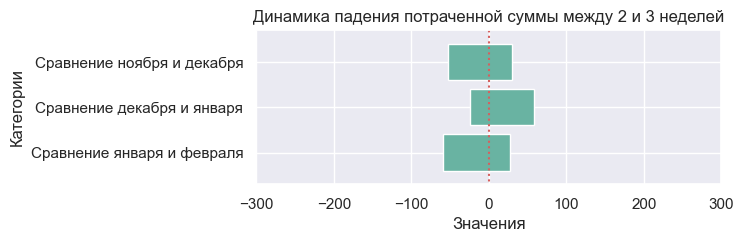

In [56]:
categories = ['Сравнение ноября и декабря', 'Сравнение декабря и января', 'Сравнение января и февраля'][::-1]
lefts = [result[0][1][0], result[1][1][0], result[2][1][0]][::-1]
values = [result[0][1][1], result[1][1][1], result[2][1][1]][::-1]

fig, ax = plt.subplots(figsize=(6, 2))

bars = ax.barh(categories, values, color='#69b3a2')

for bar, left in zip(bars, lefts):
    bar.set_x(left)
    bar.set_width(bar.get_width() - left)
plt.ylim(-0.7, 2.7)
plt.vlines(0, ymin=-1, ymax=3, color='#D65F5F', linestyles='dotted')
ax.set_ylabel('Категории')
ax.set_xlabel('Значения')
ax.set_title('Динамика падения потраченной суммы между 2 и 3 неделей')
plt.xlim(-300, 300)
plt.savefig("output.jpg", dpi=500)
plt.show()

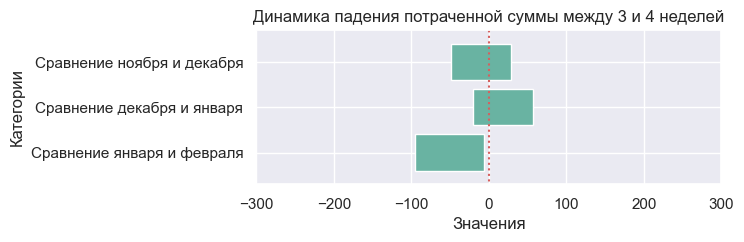

In [57]:
categories = ['Сравнение ноября и декабря', 'Сравнение декабря и января', 'Сравнение января и февраля'][::-1]
lefts = [result[0][2][0], result[1][2][0], result[2][2][0]][::-1]
values = [result[0][2][1], result[1][2][1], result[2][2][1]][::-1]

fig, ax = plt.subplots(figsize=(6, 2))

bars = ax.barh(categories, values, color='#69b3a2')

for bar, left in zip(bars, lefts):
    bar.set_x(left)
    bar.set_width(bar.get_width() - left)
plt.ylim(-0.7, 2.7)
plt.vlines(0, ymin=-1, ymax=3, color='#D65F5F', linestyles='dotted')
ax.set_ylabel('Категории')
ax.set_xlabel('Значения')
ax.set_title('Динамика падения потраченной суммы между 3 и 4 неделей')
plt.xlim(-300, 300)
plt.savefig("output.jpg", dpi=500)
plt.show()

In [58]:
purchases = pd.read_csv('purchases_processed.csv', usecols=['client_id', 'purchase_sum', 'first_issue_date', 'transaction_datetime', 'weeks_since_card'])

In [59]:
purchases = pd.read_csv('purchases_processed.csv', usecols=['client_id', 'purchase_sum', 'first_issue_date', 'transaction_datetime', 'weeks_since_card'])
purchases['new_client'] = purchases.weeks_since_card.apply(lambda x: 1 if x <= 3 else 0)
purchases['period'] = pd.to_datetime(purchases.transaction_datetime).dt.to_period('M')
purchases['card_period'] = pd.to_datetime(purchases.first_issue_date).dt.to_period('M')

In [60]:
new_cl = purchases.groupby(['client_id', 'card_period', 'new_client']).purchase_sum.sum().reset_index()
new_cl = new_cl[new_cl.new_client == 1][['card_period', 'purchase_sum']]
cl = new_cl.groupby(['card_period']).purchase_sum.mean().astype(int).reset_index()

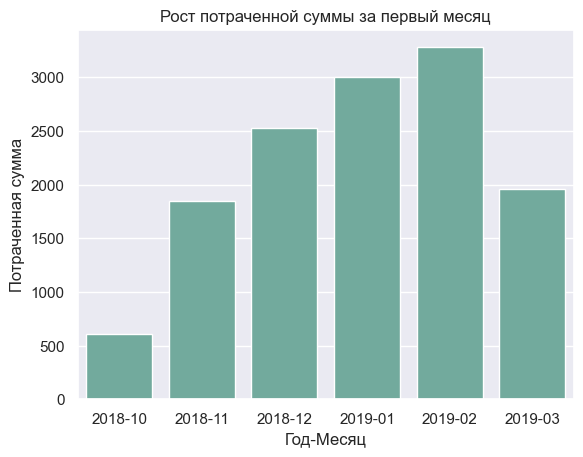

In [61]:
sns.barplot(cl, x='card_period', y='purchase_sum', color='#69b3a2')
plt.xlabel('Год-Месяц')
plt.ylabel('Потраченная сумма')
plt.title('Рост потраченной суммы за первый месяц')
plt.savefig('output.jpg', dpi=500)
plt.show()

In [62]:
old_cl = purchases.groupby(['client_id', 'period', 'new_client']).purchase_sum.sum().reset_index()
old_cl = old_cl[old_cl.new_client == 0][['period', 'purchase_sum']]
old_cl = old_cl.groupby('period').purchase_sum.mean().astype(int).reset_index()
cl['new_client'] = 1
old_cl['new_client'] = 0
cl.columns = ['period', 'purchase_sum', 'new_client']
old_cl = pd.concat((cl.iloc[1:, :], old_cl))
old_cl.columns = ['Год-Месяц', 'Средняя потраченная сумма за месяц', 'Новый клиент']
old_cl[''] = old_cl['Новый клиент'].replace({0:'Старый клиент', 1: 'Новый клиент'})

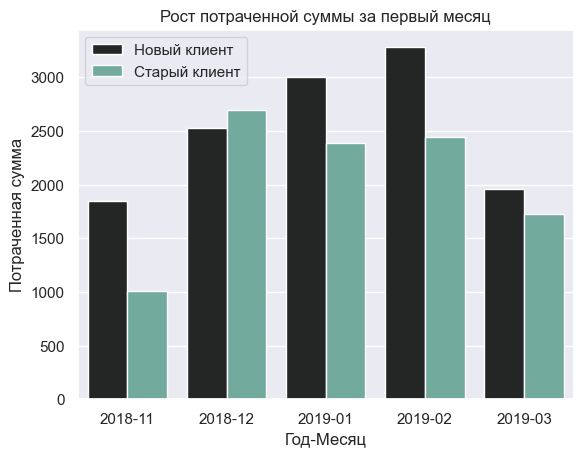

In [63]:
sns.set_theme(style="darkgrid")
sns.barplot(old_cl, x='Год-Месяц', y='Средняя потраченная сумма за месяц', hue='',color='#69b3a2')
plt.xlabel('Год-Месяц')
plt.ylabel('Потраченная сумма')
plt.title('Рост потраченной суммы за первый месяц')
#plt.savefig('output.jpg', dpi=500)
plt.show()

In [64]:
purchases = pd.read_csv('purchases_processed.csv', usecols=['client_id', 'purchase_sum', 'first_issue_date', 'transaction_datetime', 'weeks_since_card'])
purchases['new_client'] = purchases.weeks_since_card.apply(lambda x: 1 if x <= 3 else 0)
purchases['period'] = pd.to_datetime(purchases.transaction_datetime).dt.to_period('M')
purchases['card_period'] = pd.to_datetime(purchases.first_issue_date).dt.to_period('M')

In [65]:
old_cl = purchases.groupby(['client_id', 'period', 'new_client']).purchase_sum.sum().reset_index()
old_cl = old_cl[old_cl.new_client == 0][['period', 'purchase_sum']]
old_cl = old_cl.groupby('period').purchase_sum.mean().astype(int).reset_index()
new_cl = purchases[(purchases.weeks_since_card >= 1) 
          & (purchases.weeks_since_card <= 3)].groupby(['client_id', 'card_period']).purchase_sum.sum().reset_index()
old_cl.purchase_sum = np.round(old_cl.purchase_sum * 3/4).astype(int)
old_cl['new_client'] = 0
new_cl = new_cl.groupby('card_period').purchase_sum.mean().astype(int).reset_index()
new_cl.columns = ['period', 'purchase_sum']
new_cl['new_client'] = 1
old_cl = pd.concat((old_cl, new_cl.iloc[1:, :])).reset_index(drop=True)
old_cl.columns = ['Год-Месяц', 'Средняя потраченная сумма за месяц', 'Новый клиент']
old_cl = old_cl.sort_values('Новый клиент', ascending=False)
old_cl[''] = old_cl['Новый клиент'].replace({0: 'Старый клиент', 1: 'Новый клиент'})

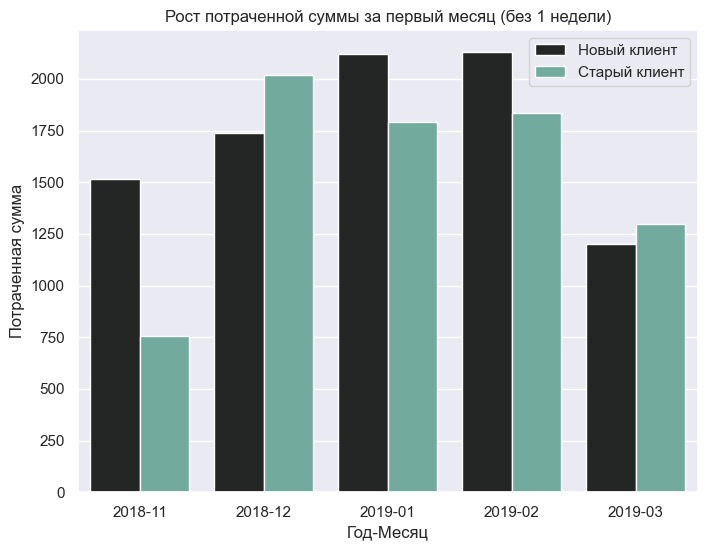

In [66]:
plt.figure(figsize=(8, 6))
sns.barplot(old_cl, x='Год-Месяц', y='Средняя потраченная сумма за месяц', hue='', color='#69b3a2')
plt.xlabel('Год-Месяц')
plt.ylabel('Потраченная сумма')
plt.title('Рост потраченной суммы за первый месяц (без 1 недели)')
#plt.savefig('output.jpg', dpi=500)
plt.show()

In [67]:
purchases = pd.read_csv('purchases_processed.csv', usecols=['client_id', 'purchase_sum', 'first_issue_date', 'transaction_datetime', 'weeks_since_card'])
purchases['new_client'] = purchases.weeks_since_card.apply(lambda x: 1 if x <= 3 else 0)
purchases['period'] = pd.to_datetime(purchases.transaction_datetime).dt.to_period('M')
purchases['card_period'] = pd.to_datetime(purchases.first_issue_date).dt.to_period('M')

In [68]:
old_cl = purchases.groupby(['client_id', 'period', 'new_client']).purchase_sum.sum().reset_index()
old_cl = old_cl[old_cl.new_client == 0][['period', 'purchase_sum']]
old_cl = old_cl.groupby('period').purchase_sum.mean().astype(int).reset_index()
new_cl = purchases[(purchases.weeks_since_card >= 2) 
          & (purchases.weeks_since_card <= 3)].groupby(['client_id', 'card_period']).purchase_sum.sum().reset_index()
old_cl.purchase_sum = np.round(old_cl.purchase_sum / 2).astype(int)
old_cl['new_client'] = 0
new_cl = new_cl.groupby('card_period').purchase_sum.mean().astype(int).reset_index()
new_cl.columns = ['period', 'purchase_sum']
new_cl['new_client'] = 1
old_cl = pd.concat((old_cl, new_cl.iloc[1:, :])).reset_index(drop=True)
old_cl.columns = ['Год-Месяц', 'Средняя потраченная сумма за месяц', 'Новый клиент']

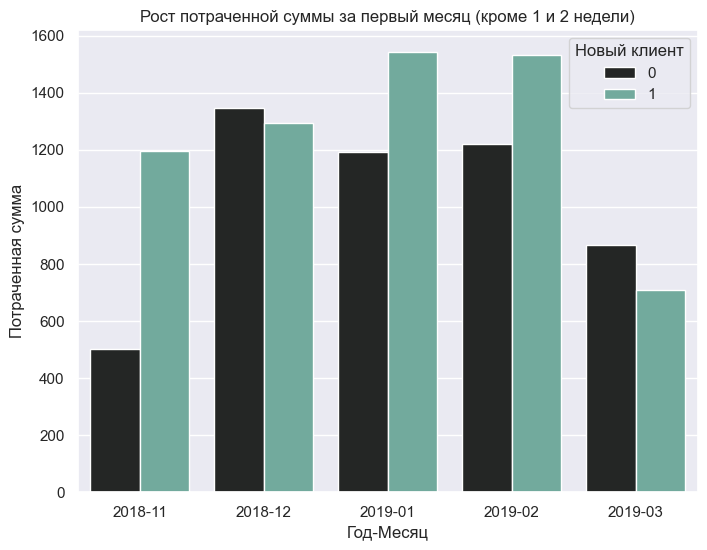

In [69]:
plt.figure(figsize=(8, 6))
sns.barplot(old_cl, x='Год-Месяц', y='Средняя потраченная сумма за месяц', hue='Новый клиент',color='#69b3a2')
plt.xlabel('Год-Месяц')
plt.ylabel('Потраченная сумма')
plt.title('Рост потраченной суммы за первый месяц (кроме 1 и 2 недели)')
#plt.savefig('output.jpg', dpi=500)
plt.show()

In [70]:
new_cl = purchases[(purchases.weeks_since_card >= 0) 
          & (purchases.weeks_since_card <= 3)].groupby(['client_id', 'card_period', 'weeks_since_card']).purchase_sum.sum().reset_index()
new_cl = new_cl.groupby(['weeks_since_card', 'card_period']).purchase_sum.mean().astype(int).reset_index()
new_cl = new_cl.pivot_table(index='card_period', columns='weeks_since_card', values='purchase_sum').fillna(0).astype(int).reset_index()
new_cl = new_cl.iloc[1:5, :]
new_cl['total'] = new_cl.iloc[:, 1:].sum(axis=1)
new_cl.columns = ['card_period', '0', '1', '2', '3', 'total']

In [71]:
new_cl['0'] = np.round(new_cl['0'] / new_cl['total'] * 100).astype(int)
new_cl['1'] = np.round(new_cl['1'] / new_cl['total'] * 100).astype(int)
new_cl['2'] = np.round(new_cl['2'] / new_cl['total'] * 100).astype(int)
new_cl['3'] = np.round(new_cl['3'] / new_cl['total'] * 100).astype(int)
new_cl = new_cl[['card_period', '0', '1', '2', '3']]
new_cl = new_cl.melt(id_vars=['card_period'], value_vars=['0', '1', '2', '3'], var_name='weeks', value_name='ratio')

In [72]:
new_cl.columns = ['Период', 'Неделя', 'Доля, %']

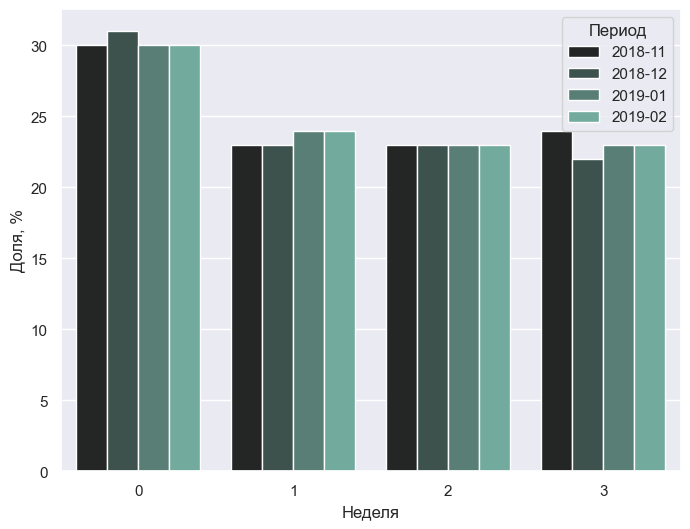

In [73]:
plt.figure(figsize=(8, 6))
sns.barplot(new_cl, x='Неделя', y='Доля, %', hue='Период', color='#69b3a2')
#plt.savefig('output.jpg', dpi=500)
plt.show()

In [76]:
clients = pd.read_csv('clients.csv', usecols=['client_id', 'first_issue_date'])
clients['period'] = pd.to_datetime(clients.first_issue_date).dt.to_period('M')
clients = clients.groupby('period').client_id.count().reset_index()
clients.rename({'client_id': 'Количество новых клиентов', 'period': 'Дата'}, axis=1, inplace=True)

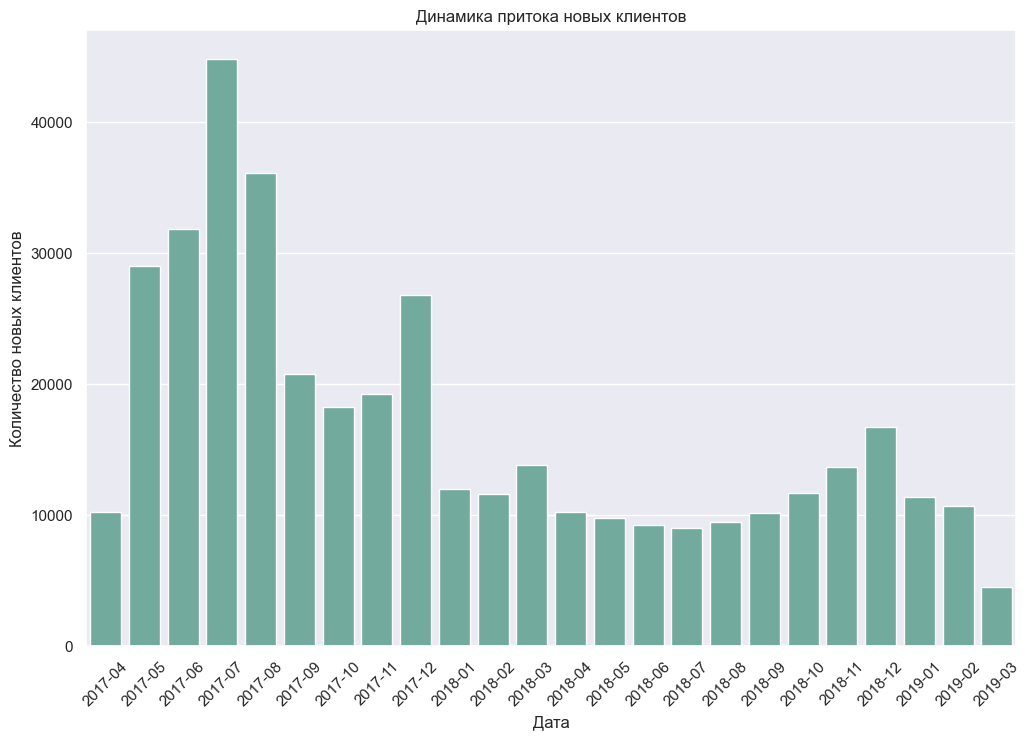

In [79]:
plt.figure(figsize=(12, 8))
sns.barplot(clients, x='Дата', y='Количество новых клиентов', color='#69b3a2')
plt.xticks(rotation=45)
plt.title('Динамика притока новых клиентов')
#plt.savefig('output.jpg', dpi=500)
plt.show()

In [80]:
purchases = pd.read_csv('purchases_processed.csv', usecols=['transaction_datetime', 'purchase_sum', 'gender'])

In [81]:
purchases = purchases.groupby(['transaction_datetime', 'gender']).purchase_sum.mean().reset_index()
p1 = purchases.groupby('gender').purchase_sum.mean().astype(int).reset_index()
p2 = purchases[purchases.transaction_datetime == '2018-12-30'][['gender', 'purchase_sum']]

In [82]:
p1 = pd.merge(p1, p2, on='gender')
p1.columns = ['gender', 'purchase_sum_mean', 'purchase_sum_30_dec']
p1['diff'] = p1['purchase_sum_30_dec'] - p1['purchase_sum_mean']
p1['ratio'] = p1['purchase_sum_30_dec'] / p1['purchase_sum_mean']

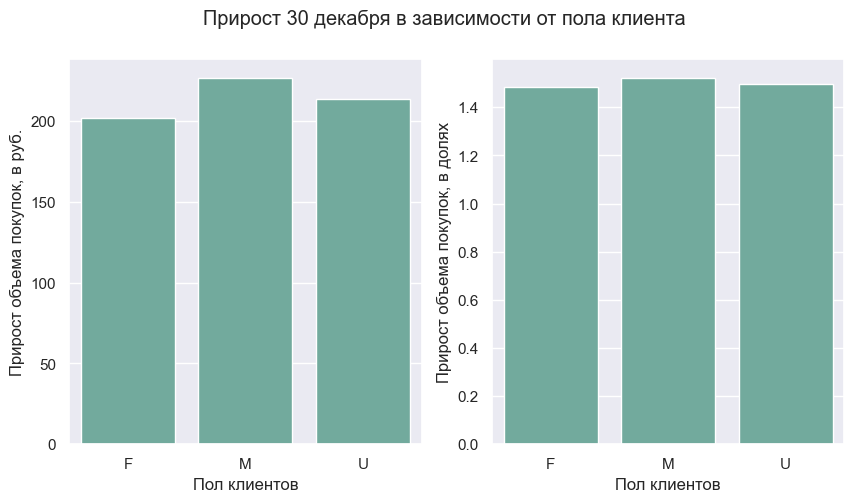

In [83]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 5))
plt.subplot(121)
sns.barplot(p1, x='gender', y='diff', color='#69b3a2')
plt.ylabel('Прирост объема покупок, в руб.')
plt.xlabel('Пол клиентов')
plt.subplot(122)
sns.barplot(p1, x='gender', y='ratio', color='#69b3a2')
plt.ylabel('Прирост объема покупок, в долях')
plt.xlabel('Пол клиентов')
plt.suptitle('Прирост 30 декабря в зависимости от пола клиента')
#plt.savefig('output.jpg', dpi=500)
plt.show()

In [85]:
purchases = pd.read_csv('purchases_processed.csv', usecols=['client_id', 'transaction_datetime', 'purchase_sum', 'gender'])

In [86]:
purch = purchases.groupby(['client_id', 'transaction_datetime', 'gender']).purchase_sum.sum().reset_index()
purch = purch[purch.gender != 'U'].groupby(['transaction_datetime', 'gender']).purchase_sum.mean().astype(int).reset_index()

In [87]:
women_mean = purch[purch.gender == 'F'].purchase_sum.mean().astype(int)
men_mean = purch[purch.gender == 'M'].purchase_sum.mean().astype(int)

In [88]:
men = purchases[(purchases.transaction_datetime == '2018-12-30') & (purchases.gender == 'M')].groupby('client_id').purchase_sum.sum().to_numpy()
women = purchases[(purchases.transaction_datetime == '2018-12-30') & (purchases.gender == 'F')].groupby('client_id').purchase_sum.sum().to_numpy()

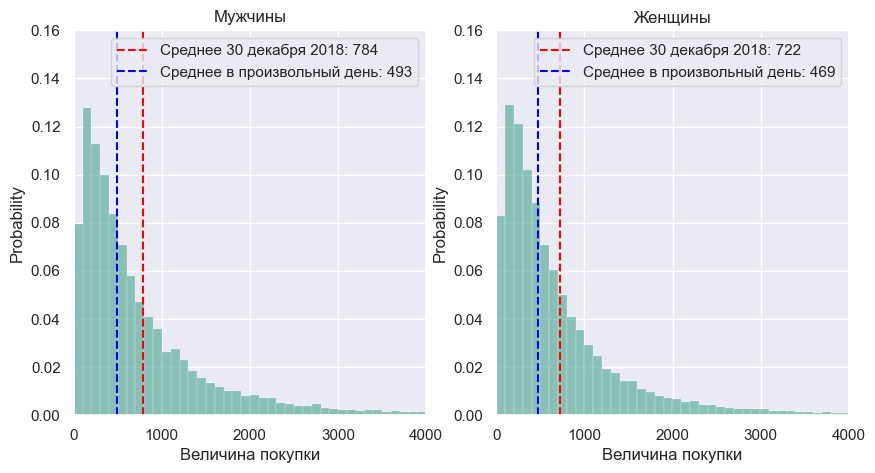

In [89]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title('Мужчины')
sns.histplot(men, stat='probability', color='#69b3a2', binwidth=100)
plt.vlines(x=men.mean(), ymin=0, ymax=0.16, linestyles='dashed',  colors='red', label=f'Среднее 30 декабря 2018: {men.mean().astype(int)}')
plt.vlines(x=men_mean, ymin=0, ymax=0.16, linestyles='dashed',  colors='blue', label=f'Среднее в произвольный день: {men_mean}')
plt.xlabel('Величина покупки')
plt.legend()
plt.xlim(0, 4000)
plt.ylim(0, 0.16)
plt.subplot(122)
plt.title('Женщины')
sns.histplot(women, stat='probability', color='#69b3a2', binwidth=100)
plt.vlines(x=women.mean(), ymin=0, ymax=0.16, linestyles='dashed',  colors='red', label=f'Среднее 30 декабря 2018: {women.mean().astype(int)}')
plt.vlines(x=women_mean, ymin=0, ymax=0.16, linestyles='dashed',  colors='blue', label=f'Среднее в произвольный день: {women_mean}')
plt.xlabel('Величина покупки')
plt.legend()
plt.xlim(0, 4000)
plt.ylim(0, 0.16)
plt.savefig('output.jpg', dpi=500)
plt.show()

In [90]:
def bootstrap_mean_confidence_interval(data, n_bootstrap=10000, alpha=0.05):
    boot_means = []
    n = len(data)
    for _ in range(n_bootstrap):
        boot_sample = np.random.choice(data, size=n, replace=True)
        boot_means.append(np.mean(boot_sample))
    lower = np.percentile(boot_means, 100 * alpha / 2)
    upper = np.percentile(boot_means, 100 * (1 - alpha / 2))
    return lower, upper, boot_means

In [92]:
lower_men, upper_men, boot_means_men = bootstrap_mean_confidence_interval(men, n_bootstrap=10000, alpha=0.05)
lower_women, upper_women, boot_means_women = bootstrap_mean_confidence_interval(women, n_bootstrap=10000, alpha=0.05)

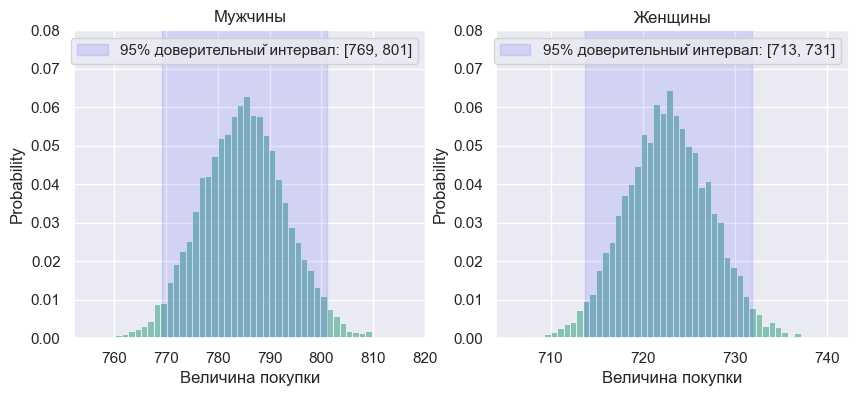

In [93]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title('Мужчины')
sns.histplot(np.array(boot_means_men), stat='probability', color='#69b3a2', bins=50)
plt.fill_between([lower_men, upper_men], [0.1, 0.1], color='blue', alpha=0.1, label=f'95% доверительный интервал: [{lower_men.astype(int)}, {upper_men.astype(int)}]')
plt.ylim(0, 0.08)
plt.legend()
plt.xlabel('Величина покупки')
plt.subplot(122)
plt.title('Женщины')
sns.histplot(np.array(boot_means_women), stat='probability', color='#69b3a2', bins=50)
plt.fill_between([lower_women, upper_women], [0.1, 0.1], color='blue', alpha=0.1, label=f'95% доверительный интервал: [{lower_women.astype(int)}, {upper_women.astype(int)}]')
plt.xlabel('Величина покупки')
plt.ylim(0, 0.08)
plt.legend()
#plt.savefig('output.jpg', dpi=500)
plt.show()